# 1. Discretise and assemble H

In [1]:
import numpy as np
from scipy.sparse import diags

def construct_hamiltonian(L, N, potential_type='square_well'):
    """
    Construct the Hamiltonian matrix H for a given domain length L and grid size N.

    Parameters:
    L (float): Domain length.
    N (int): Grid size.
    potential_type (str): Type of potential ('square_well', 'harmonic', 'double_shallow', etc.).

    Returns:
    H (numpy.ndarray): Hamiltonian matrix (N x N).
    x (numpy.ndarray): Grid vector.
    dx (float): Grid spacing.
    """
    # Grid spacing and vector
    dx = L / (N - 1)
    x = np.linspace(-L / 2, L / 2, N)

    # Potential function
    def V(x, potential_type):
        if potential_type == 'square_well':
            return np.zeros_like(x)
        elif potential_type == 'harmonic':
            return 0.5 * x**2  # Assuming m = 1 and omega = 1
        elif potential_type == 'double_shallow':
            a = 5.0
            b = 1.2
            return a * (x**2 - b**2)**2
        elif potential_type == 'double_medium':
            a = 1e3
            b = 1.5
            return a * (x**2 - b**2)**2
        elif potential_type == 'double_extreme':
            a = 1e5
            b = 2.0
            return a * (x**2 - b**2)**2

    V_x = V(x, potential_type)

    # Construct the kinetic energy matrix T
    T_diagonal = -2 * np.ones(N) / dx**2
    T_off_diagonal = np.ones(N - 1) / dx**2

    T = diags([T_diagonal, T_off_diagonal, T_off_diagonal], [0, -1, 1]).toarray()

    # Construct the potential energy matrix V
    V_matrix = diags([V_x], [0]).toarray()

    # Construct the Hamiltonian matrix H
    H = (-0.5) * T + V_matrix  # Assuming h_bar = 1 and m = 1

    return H, x, dx

# Example usage
L = 6.0
N_small = 5  # Small N for demonstration
N_large = 100  # Large N for symmetry verification

H_small, x_small, dx_small = construct_hamiltonian(L, N_small, potential_type='harmonic')
H_large, x_large, dx_large = construct_hamiltonian(L, N_large, potential_type='harmonic')

print("Hamiltonian matrix for N =", N_small)
print(H_small)

# Verify symmetry for large N
is_symmetric = np.allclose(H_large, H_large.T)
print("\nIs the Hamiltonian matrix symmetric for N =", N_large, "?", is_symmetric)


Hamiltonian matrix for N = 5
[[ 4.94444444 -0.22222222  0.          0.          0.        ]
 [-0.22222222  1.56944444 -0.22222222  0.          0.        ]
 [ 0.         -0.22222222  0.44444444 -0.22222222  0.        ]
 [ 0.          0.         -0.22222222  1.56944444 -0.22222222]
 [ 0.          0.          0.         -0.22222222  4.94444444]]

Is the Hamiltonian matrix symmetric for N = 100 ? True


## 2. Visualise spectra

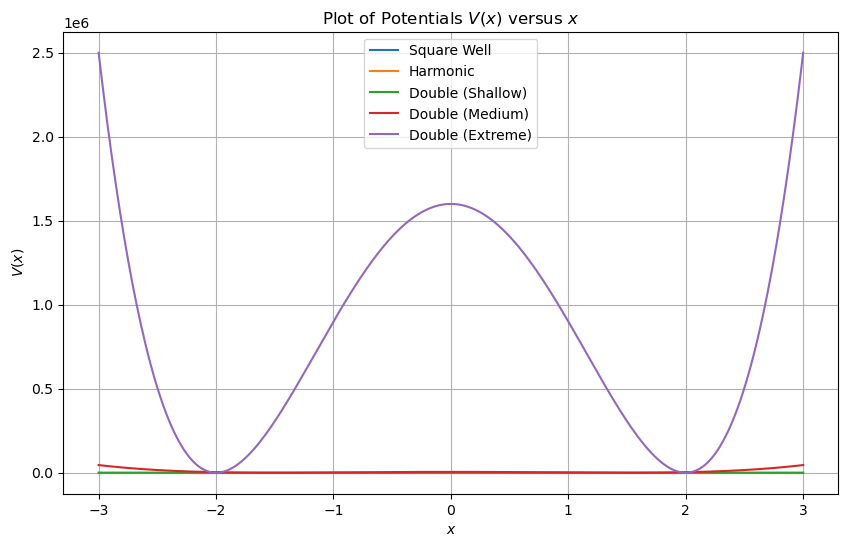

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of x
L = 6.0
x = np.linspace(-L/2, L/2, 500)

# Define the potential functions
def V_square_well(x):
    return np.zeros_like(x)

def V_harmonic(x, omega=1.0):
    return 0.5 * (x**2)

def V_double_shallow(x, a=5.0, b=1.2):
    return a * (x**2 - b**2)**2

def V_double_medium(x, a=1e3, b=1.5):
    return a * (x**2 - b**2)**2

def V_double_extreme(x, a=1e5, b=2.0):
    return a * (x**2 - b**2)**2

# Define the potentials
potentials = {
    "Square Well": V_square_well,
    "Harmonic": V_harmonic,
    "Double (Shallow)": V_double_shallow,
    "Double (Medium)": V_double_medium,
    "Double (Extreme)": V_double_extreme
}

# Plot the potentials
plt.figure(figsize=(10, 6))
for name, potential_func in potentials.items():
    plt.plot(x, potential_func(x), label=name)

plt.title("Plot of Potentials $V(x)$ versus $x$")
plt.xlabel("$x$")
plt.ylabel("$V(x)$")
plt.legend()
plt.grid(True)
plt.show()


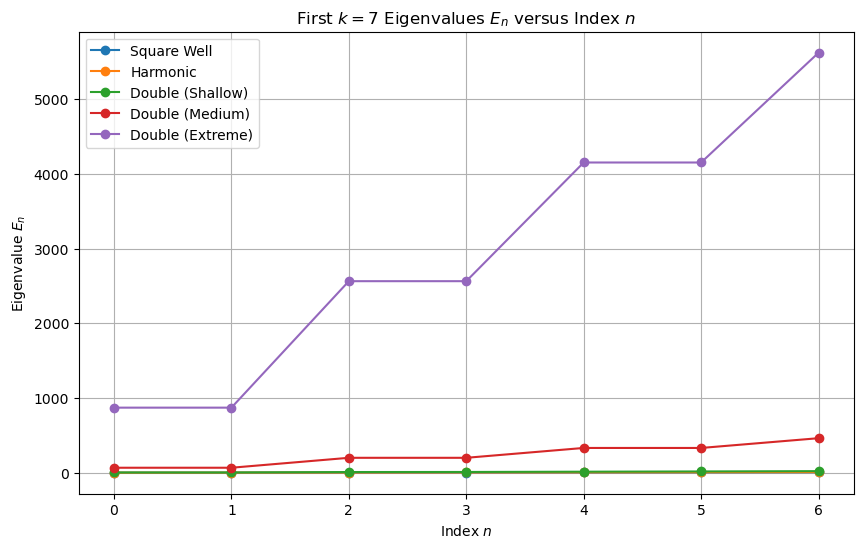

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Constants
L = 6.0
N = 400  # Grid size
k = 7  # Number of eigenvalues to compute

# Potential functions
def V_square_well(x):
    return np.zeros_like(x)

def V_harmonic(x, omega=1.0):
    return 0.5 * (x**2)

def V_double_shallow(x, a=5.0, b=1.2):
    return a * (x**2 - b**2)**2

def V_double_medium(x, a=1e3, b=1.5):
    return a * (x**2 - b**2)**2

def V_double_extreme(x, a=1e5, b=2.0):
    return a * (x**2 - b**2)**2

# Define the potentials
potentials = {
    "Square Well": V_square_well,
    "Harmonic": V_harmonic,
    "Double (Shallow)": V_double_shallow,
    "Double (Medium)": V_double_medium,
    "Double (Extreme)": V_double_extreme
}

# Function to compute eigenvalues
def compute_eigenvalues(L, N, potential_func, k):
    x = np.linspace(-L/2, L/2, N)
    dx = x[1] - x[0]

    # Construct the kinetic energy matrix T
    T = np.diag(-2 * np.ones(N)) + np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1)
    T = - (1 / (2 * dx**2)) * T

    # Construct the potential energy matrix V
    V = np.diag(potential_func(x))

    # Assemble the Hamiltonian matrix H
    H = T + V

    # Compute the eigenvalues
    eigenvalues = eigh(H, eigvals_only=True, subset_by_index=[0, k-1])

    return eigenvalues

# Plot the eigenvalues
plt.figure(figsize=(10, 6))
for name, potential_func in potentials.items():
    eigenvalues = compute_eigenvalues(L, N, potential_func, k)
    plt.plot(range(k), eigenvalues, 'o-', label=name)

plt.title("First $k=7$ Eigenvalues $E_n$ versus Index $n$")
plt.xlabel("Index $n$")
plt.ylabel("Eigenvalue $E_n$")
plt.legend()
plt.grid(True)
plt.show()


## 3. Condition number and ground-state error

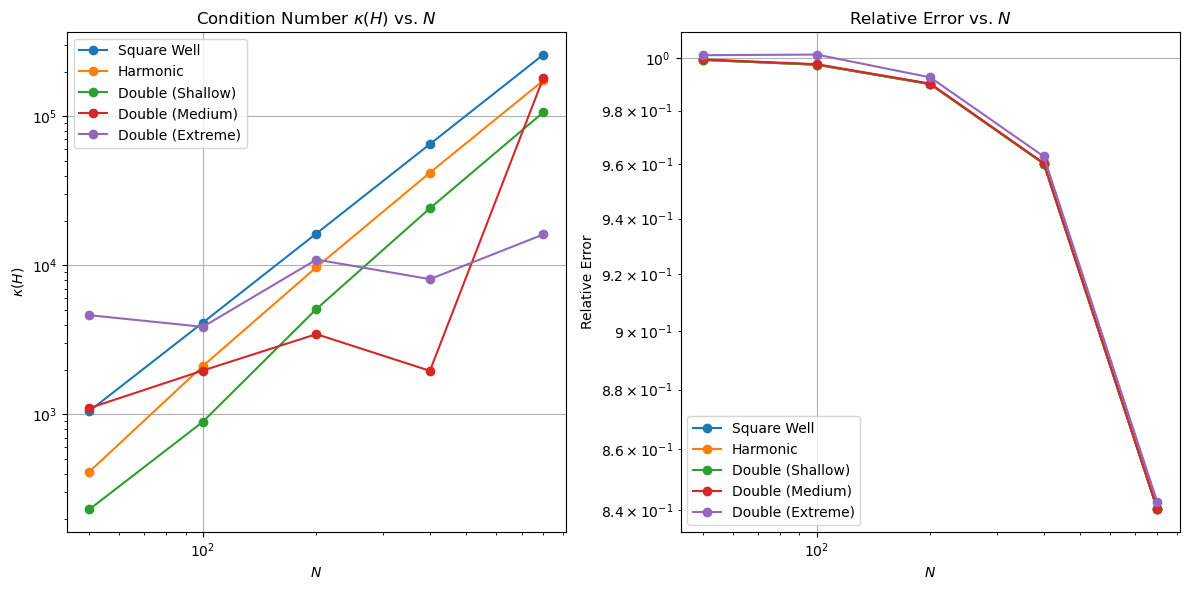

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh

# Constants
L = 6.0
N_values = [50, 100, 200, 400, 800]
N_ref = 2000
k = 1  # We only need the first eigenvalue for the ground state energy

# Potential functions
def V_square_well(x):
    return np.zeros_like(x)

def V_harmonic(x, omega=1.0):
    return 0.5 * x**2

def V_double_shallow(x, a=5.0, b=1.2):
    return a * (x**2 - b**2)**2

def V_double_medium(x, a=1e3, b=1.5):
    return a * (x**2 - b**2)**2

def V_double_extreme(x, a=1e5, b=2.0):
    return a * (x**2 - b**2)**2

# Define the potentials
potentials = {
    "Square Well": V_square_well,
    "Harmonic": V_harmonic,
    "Double (Shallow)": V_double_shallow,
    "Double (Medium)": V_double_medium,
    "Double (Extreme)": V_double_extreme
}

# Function to compute the condition number and relative error
def compute_condition_number_and_error(L, N, potential_func, N_ref):
    x = np.linspace(-L/2, L/2, N)
    dx = x[1] - x[0]

    # Construct the kinetic energy matrix T
    T = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

    # Construct the potential energy matrix V
    V = diags(potential_func(x), 0)

    # Assemble the Hamiltonian matrix H
    H = T + V
    H_dense = H.toarray()

    # Compute the condition number
    condition_number = np.linalg.cond(H_dense)

    # Compute the first eigenvalue E0(N)
    E0_N = eigsh(H, k=k, which='SA')[0][0]

    # Compute the reference eigenvalue E0(N_ref)
    x_ref = np.linspace(-L/2, L/2, N_ref)
    dx_ref = x_ref[1] - x_ref[0]
    T_ref = diags([1, -2, 1], [-1, 0, 1], shape=(N_ref, N_ref)) / dx_ref**2
    V_ref = diags(potential_func(x_ref), 0)
    H_ref = T_ref + V_ref
    E0_ref = eigsh(H_ref, k=k, which='SA')[0][0]

    # Compute the relative error
    relative_error = np.abs(E0_N - E0_ref) / np.abs(E0_ref)

    return condition_number, relative_error

# Compute the condition number and relative error for each potential and grid size
results = {name: {'condition_numbers': [], 'relative_errors': []} for name in potentials}

for name, potential_func in potentials.items():
    for N in N_values:
        condition_number, relative_error = compute_condition_number_and_error(L, N, potential_func, N_ref)
        results[name]['condition_numbers'].append(condition_number)
        results[name]['relative_errors'].append(relative_error)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot condition number vs. N
plt.subplot(1, 2, 1)
for name, result in results.items():
    plt.loglog(N_values, result['condition_numbers'], 'o-', label=name)
plt.title("Condition Number $\\kappa(H)$ vs. $N$")
plt.xlabel("$N$")
plt.ylabel("$\\kappa(H)$")
plt.legend()
plt.grid(True)

# Plot relative error vs. N
plt.subplot(1, 2, 2)
for name, result in results.items():
    plt.loglog(N_values, result['relative_errors'], 'o-', label=name)
plt.title("Relative Error vs. $N$")
plt.xlabel("$N$")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 4. Spike test

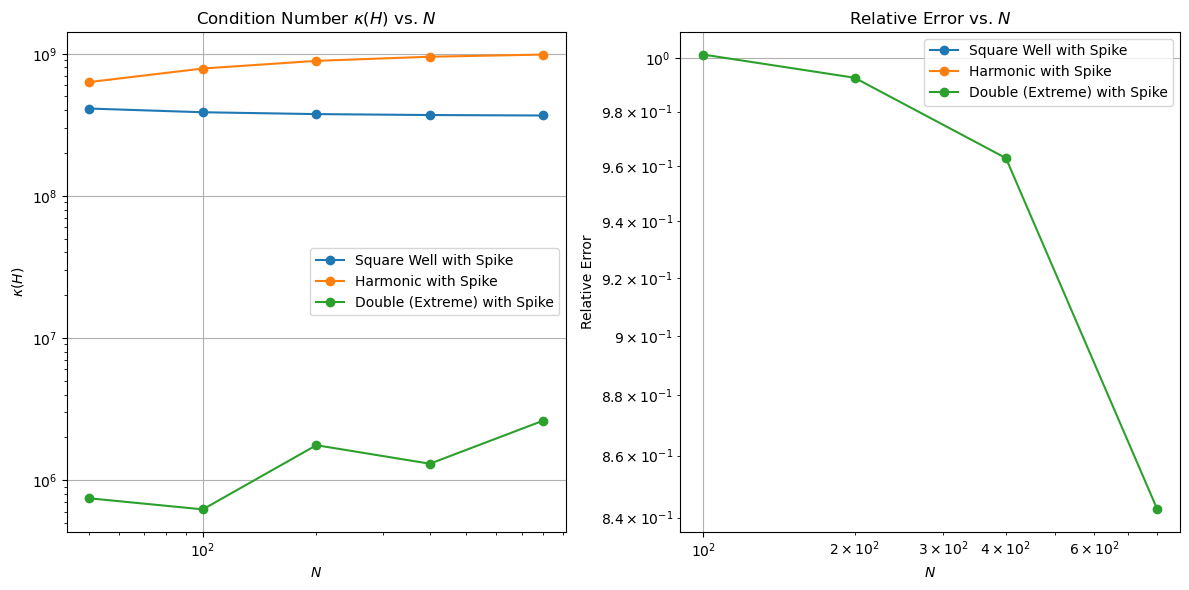

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh

# Constants
L = 6.0
N_values = [50, 100, 200, 400, 800]
N_ref = 2000
k = 1  # We only need the first eigenvalue for the ground state energy
h = 100

# Potential functions with spike
def V_square_well_with_spike(x):
    V_spike = h * N_ref**2
    spike = np.zeros_like(x)
    spike[len(x)//2] = V_spike
    return np.zeros_like(x) + spike

def V_harmonic_with_spike(x, omega=1.0):
    V_spike = h * N_ref**2
    spike = np.zeros_like(x)
    spike[len(x)//2] = V_spike
    return 0.5 * x**2 + spike

def V_double_extreme_with_spike(x, a=1e5, b=2.0):
    V_spike = h * N_ref**2
    spike = np.zeros_like(x)
    spike[len(x)//2] = V_spike
    return a * (x**2 - b**2)**2 + spike

# Define the potentials with spike
potentials_with_spike = {
    "Square Well with Spike": V_square_well_with_spike,
    "Harmonic with Spike": V_harmonic_with_spike,
    "Double (Extreme) with Spike": V_double_extreme_with_spike
}

# Function to compute the condition number and relative error
def compute_condition_number_and_error(L, N, potential_func, N_ref):
    x = np.linspace(-L/2, L/2, N)
    dx = x[1] - x[0]

    # Construct the kinetic energy matrix T
    T = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

    # Construct the potential energy matrix V
    V = diags(potential_func(x), 0)

    # Assemble the Hamiltonian matrix H
    H = T + V
    H_dense = H.toarray()

    # Compute the condition number
    condition_number = np.linalg.cond(H_dense)

    # Compute the first eigenvalue E0(N)
    try:
        E0_N = eigsh(H, k=k, which='SA', maxiter=10000)[0][0]
    except:
        E0_N = np.nan

    # Compute the reference eigenvalue E0(N_ref)
    x_ref = np.linspace(-L/2, L/2, N_ref)
    dx_ref = x_ref[1] - x_ref[0]
    T_ref = diags([1, -2, 1], [-1, 0, 1], shape=(N_ref, N_ref)) / dx_ref**2
    V_ref = diags(potential_func(x_ref), 0)
    H_ref = T_ref + V_ref
    try:
        E0_ref = eigsh(H_ref, k=k, which='SA', maxiter=10000)[0][0]
    except:
        E0_ref = np.nan

    # Compute the relative error
    relative_error = np.abs(E0_N - E0_ref) / np.abs(E0_ref) if not np.isnan(E0_ref) else np.nan

    return condition_number, relative_error

# Compute the condition number and relative error for each potential with spike and grid size
results_with_spike = {name: {'condition_numbers': [], 'relative_errors': []} for name in potentials_with_spike}

for name, potential_func in potentials_with_spike.items():
    for N in N_values:
        condition_number, relative_error = compute_condition_number_and_error(L, N, potential_func, N_ref)
        results_with_spike[name]['condition_numbers'].append(condition_number)
        results_with_spike[name]['relative_errors'].append(relative_error)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot condition number vs. N
plt.subplot(1, 2, 1)
for name, result in results_with_spike.items():
    plt.loglog(N_values, result['condition_numbers'], 'o-', label=name)
plt.title("Condition Number $\\kappa(H)$ vs. $N$")
plt.xlabel("$N$")
plt.ylabel("$\\kappa(H)$")
plt.legend()
plt.grid(True)

# Plot relative error vs. N
plt.subplot(1, 2, 2)
for name, result in results_with_spike.items():
    plt.loglog(N_values, result['relative_errors'], 'o-', label=name)
plt.title("Relative Error vs. $N$")
plt.xlabel("$N$")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. Spike height sweep

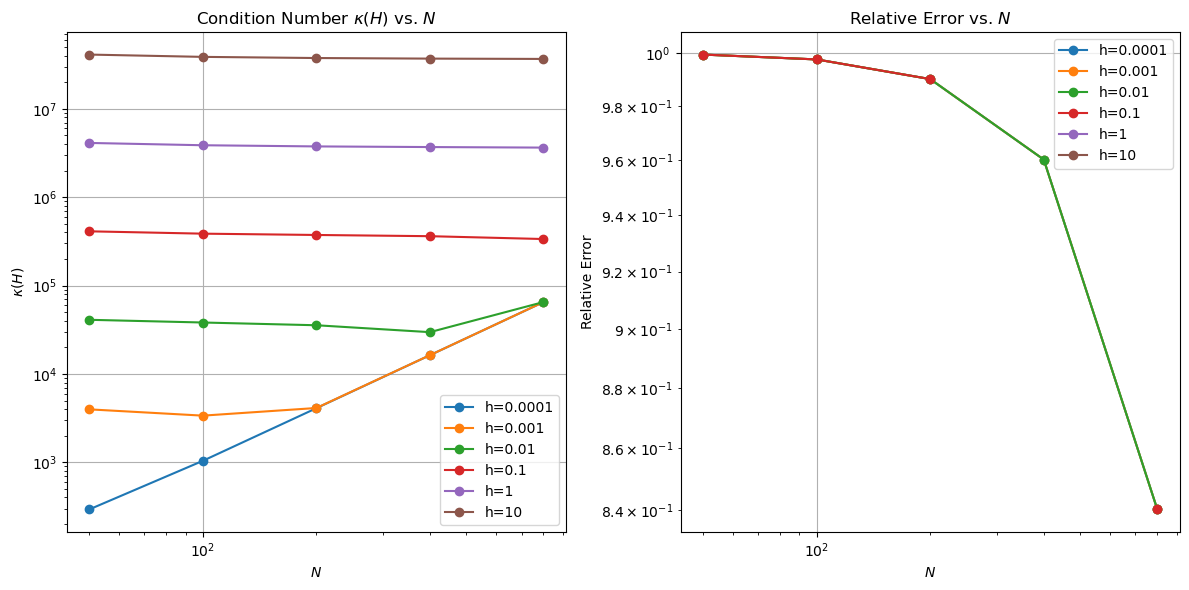

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

# Constants
L = 6.0
N_values = [50, 100, 200, 400, 800]
N_ref = 2000
k = 1  # We only need the first eigenvalue for the ground state energy
h_values = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]

# Function to compute the condition number and relative error
def compute_condition_number_and_error(L, N, potential_func, N_ref):
    x = np.linspace(-L/2, L/2, N)
    dx = x[1] - x[0]

    # Construct the kinetic energy matrix T
    T = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

    # Construct the potential energy matrix V
    V = diags(potential_func(x), 0)

    # Assemble the Hamiltonian matrix H
    H = T + V
    H_dense = H.toarray()

    # Compute the condition number
    condition_number = np.linalg.cond(H_dense)

    # Compute the first eigenvalue E0(N)
    try:
        E0_N = eigsh(H, k=k, which='SA', maxiter=10000)[0][0]
    except:
        E0_N = np.nan

    # Compute the reference eigenvalue E0(N_ref)
    x_ref = np.linspace(-L/2, L/2, N_ref)
    dx_ref = x_ref[1] - x_ref[0]
    T_ref = diags([1, -2, 1], [-1, 0, 1], shape=(N_ref, N_ref)) / dx_ref**2
    V_ref = diags(potential_func(x_ref), 0)
    H_ref = T_ref + V_ref
    try:
        E0_ref = eigsh(H_ref, k=k, which='SA', maxiter=10000)[0][0]
    except:
        E0_ref = np.nan

    # Compute the relative error
    relative_error = np.abs(E0_N - E0_ref) / np.abs(E0_ref) if not np.isnan(E0_ref) else np.nan

    return condition_number, relative_error

# Compute the condition number and relative error for each spike height and grid size
results_square_well = {h: {'condition_numbers': [], 'relative_errors': []} for h in h_values}

for h in h_values:
    def V_square_well_with_spike(x):
        V_spike = h * N_ref**2
        spike = np.zeros_like(x)
        spike[len(x)//2] = V_spike
        return np.zeros_like(x) + spike

    for N in N_values:
        condition_number, relative_error = compute_condition_number_and_error(L, N, V_square_well_with_spike, N_ref)
        results_square_well[h]['condition_numbers'].append(condition_number)
        results_square_well[h]['relative_errors'].append(relative_error)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot condition number vs. N
plt.subplot(1, 2, 1)
for h, result in results_square_well.items():
    plt.loglog(N_values, result['condition_numbers'], 'o-', label=f'h={h}')
plt.title("Condition Number $\\kappa(H)$ vs. $N$")
plt.xlabel("$N$")
plt.ylabel("$\\kappa(H)$")
plt.legend()
plt.grid(True)

# Plot relative error vs. N
plt.subplot(1, 2, 2)
for h, result in results_square_well.items():
    plt.loglog(N_values, result['relative_errors'], 'o-', label=f'h={h}')
plt.title("Relative Error vs. $N$")
plt.xlabel("$N$")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
